In [1]:
import numpy as np
import pandas as pd
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from scroutines import pnmf
from scroutines import basicu


In [2]:
adata = anndata.read("../../data/cheng21_cell_scrna/organized/P28NR.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 23930 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [3]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
adata

View of AnnData object with n_obs × n_vars = 4044 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'sample_new', 'layer', 'Type', 'Subclass'

In [4]:
genes

array(['4933401J01Rik', 'Gm26206', 'Xkr4', ..., 'CAAA01064564.1',
       'Vmn2r122', 'CAAA01147332.1'], dtype=object)

In [5]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

In [6]:
gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

<Axes: ylabel='Count'>

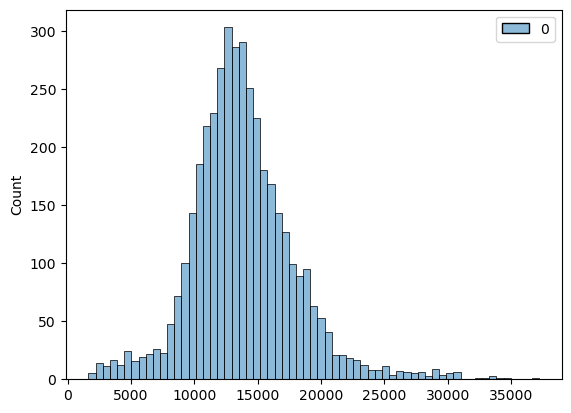

In [7]:
# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4

sns.histplot(cov)

In [8]:
w, rec = pnmf.get_pnmf(norm.T, 6, init='normal')

In [20]:
w.shape

(286, 6)

In [15]:
scale = 1e5/w.sum()
scale

5833.627571084454

In [21]:
# binarize w

In [22]:
b = np.zeros_like(w)
for coli in range(w.shape[1]):
    v = w[:,coli]
    rowi = np.argmax(v)
    b[rowi, coli] = 1 
    

<Axes: >

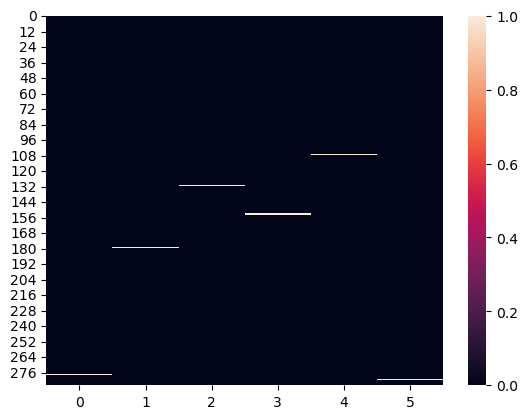

In [23]:
sns.heatmap(b) #, vmax=0.05)

In [9]:
wd, wr, wc = basicu.diag_matrix(w)
sns.heatmap(wd, vmax=0.05)

In [16]:
# prjx = norm.dot(w*scale)
# prjxz = zscore(np.log10(prjx+1), axis=0)
# rowidx = basicu.order_by_hc(prjxz)
# colidx = basicu.order_by_hc(prjxz.T)

In [ ]:
prjx = norm.dot(b)
prjxz = zscore(np.log10(prjx+1), axis=0)
rowidx = basicu.order_by_hc(prjxz)
colidx = basicu.order_by_hc(prjxz.T)

<Axes: >

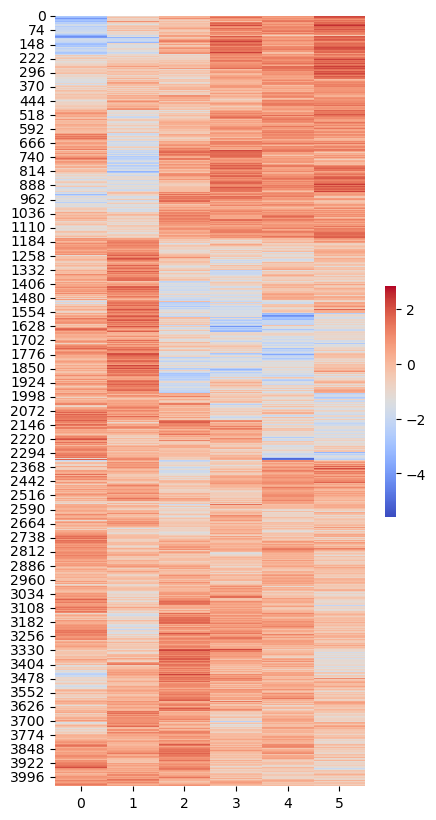

In [18]:
fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(prjxz[rowidx][:,colidx], 
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3),
            ax=ax,
            )